In [10]:
import boto3
import pandas as pd

# 1. Configuración de la conexión
# Si tienes tus credenciales configuradas en el AWS CLI, esto funcionará automáticamente.
dynamodb = boto3.resource('dynamodb', region_name='us-east-1') # Cambia la región si es necesario
table = dynamodb.Table('stock_prices')

def get_all_stock_data(dynamo_table):
    """
    Escanea la tabla completa manejando la paginación de DynamoDB.
    """
    items = []
    response = dynamo_table.scan()
    items.extend(response.get('Items', []))

    # DynamoDB tiene un límite de 1MB por respuesta, por lo que usamos paginación
    while 'LastEvaluatedKey' in response:
        response = dynamo_table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
        items.extend(response.get('Items', []))
    
    return items

# 2. Descargar los datos
print("Descargando datos de DynamoDB...")
raw_data = get_all_stock_data(table)

# 3. Convertir a DataFrame de Pandas
df = pd.DataFrame(raw_data)

# 4. Visualización rápida
print(f"Total de registros recuperados: {len(df)}")
df.sample(20)

Descargando datos de DynamoDB...
Total de registros recuperados: 24825


,low,date,ticker,open,volume,high,close
18834,11.045370902619192,2021-07-01,BMA,11.408506028548139,321800,11.537116566019314,11.189111709594727
14278,2.741854467910434,2023-02-15,SUPV,2.8296720214729567,214800,2.8296720214729567,2.7516119480133057
2122,3.1225896051962216,2020-11-06,IRS,3.1726843439237125,35465,3.306271045440742,3.2645246982574463
20084,18.52986999811542,2019-11-20,TS,18.60838653037696,2630500,18.922452659423133,18.66945457458496
13180,57.176550903474556,2025-05-07,GGAL,58.09939385340223,908300,58.77416082292653,57.90093231201172
1467,21.8700008392334,2024-10-30,TGS,22.360000610351562,120000,22.729999542236328,22.09000015258789
2904,7.839569526126588,2023-12-18,IRS,7.945509552460347,88800,8.016136236682852,7.901367664337158
13819,1.5991802290616026,2021-04-21,SUPV,1.60869926369022,255300,1.675331711769104,1.675331711769104
22997,10.71925810365676,2024-11-20,CRESY,10.957463839293576,203700,11.033689602002736,10.938406944274902
942,6.929999828338623,2022-09-28,TGS,7.039999961853027,112600,7.289999961853027,7.239999771118164


In [11]:
df["ticker"].value_counts()

ticker
TGS      1655
IRS      1655
TEO      1655
BBAR     1655
PAM      1655
MELI     1655
EDN      1655
GGAL     1655
SUPV     1655
YPF      1655
LOMA     1655
BMA      1655
TS       1655
CRESY    1655
CEPU     1655
Name: count, dtype: int64

Datos: 252 filas × 8 tickers
Frontera: 100 puntos calculados


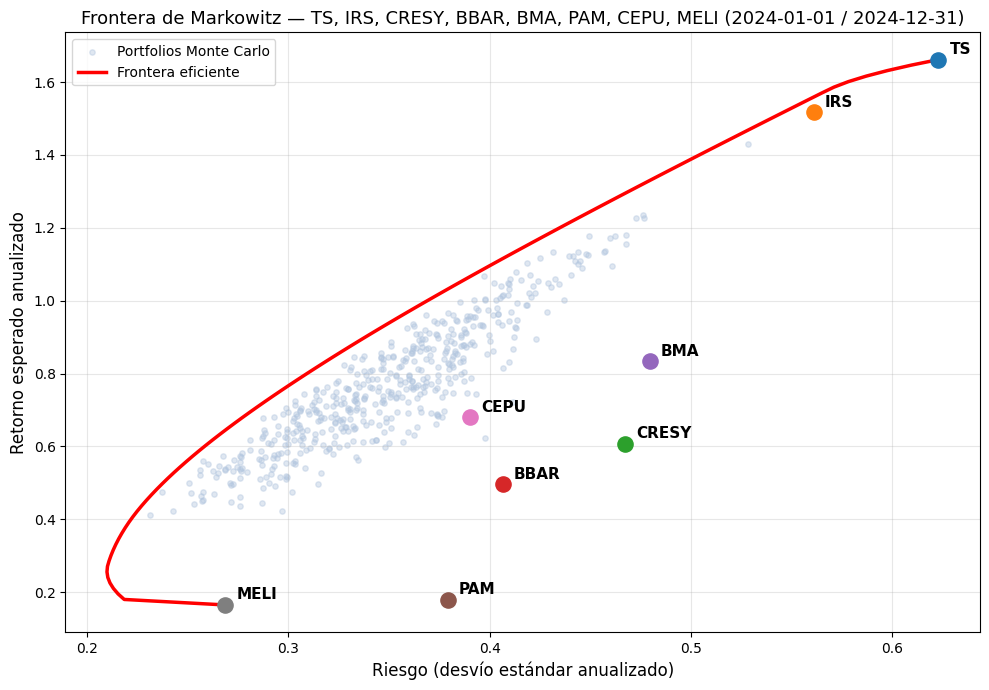

Gráfico guardado en frontier_test.png


In [ ]:
import boto3
import pandas as pd
import numpy as np
from boto3.dynamodb.conditions import Key
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ── Config ────────────────────────────────────────────────────────────────────
TICKERS    = ["TS", "IRS", "CRESY", "BBAR", "BMA", "PAM", "CEPU", "MELI"]
START_DATE = "2024-01-01"
END_DATE   = "2024-12-31"
N_POINTS   = 100       # puntos en la frontera
N_MC       = 500       # portfolios Monte Carlo de fondo

# ── 1. Bajar datos de DynamoDB ────────────────────────────────────────────────
dynamodb = boto3.resource("dynamodb", region_name="us-east-1")
table    = dynamodb.Table("stock_prices")

all_data = []
for ticker in TICKERS:
    response = table.query(
        KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(START_DATE, END_DATE)
    )
    items = response.get("Items", [])
    while "LastEvaluatedKey" in response:
        response = table.query(
            KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(START_DATE, END_DATE),
            ExclusiveStartKey=response["LastEvaluatedKey"]
        )
        items.extend(response.get("Items", []))
    all_data.extend(items)

raw_df = pd.DataFrame(all_data)
raw_df["close"] = raw_df["close"].astype(float)
df = raw_df.pivot(index="date", columns="ticker", values="close").dropna()
print(f"Datos: {len(df)} filas × {len(df.columns)} tickers")

# ── 2. Retornos y parámetros ──────────────────────────────────────────────────
daily_returns = df.pct_change().dropna()
mu  = daily_returns.mean().values * 252          # retorno anualizado
cov = daily_returns.cov().values * 252           # covarianza anualizada
n   = len(TICKERS)

# ── 3. Monte Carlo (fondo) ────────────────────────────────────────────────────
mc_risks, mc_returns = [], []
for _ in range(N_MC):
    w = np.random.dirichlet(np.ones(n))
    mc_returns.append(w @ mu)
    mc_risks.append(np.sqrt(w @ cov @ w))

# ── 4. Frontera eficiente por optimización cuadrática ─────────────────────────
def portfolio_variance(w):
    return w @ cov @ w          # minimizamos varianza (= std²)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},           # pesos suman 1
]
bounds = [(0, 1)] * n                                          # long-only

target_returns = np.linspace(min(mu), max(mu), N_POINTS)
frontier_risks, frontier_returns = [], []

for target in target_returns:
    constraints_with_return = constraints + [
        {"type": "eq", "fun": lambda w, t=target: w @ mu - t}  # retorno objetivo
    ]
    w0 = np.ones(n) / n    # punto inicial: pesos iguales
    result = minimize(
        portfolio_variance,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints_with_return,
        options={"ftol": 1e-12, "maxiter": 1000}
    )
    if result.success:
        frontier_risks.append(np.sqrt(result.fun))
        frontier_returns.append(target)

print(f"Frontera: {len(frontier_risks)} puntos calculados")

# ── 5. Activos individuales ───────────────────────────────────────────────────
asset_risks   = [np.sqrt(cov[i, i]) for i in range(n)]
asset_returns = list(mu)

# ── 6. Plot ───────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(mc_risks, mc_returns, c="lightsteelblue", alpha=0.4, s=15, label="Portfolios Monte Carlo")
ax.plot(frontier_risks, frontier_returns, "r-", linewidth=2.5, label="Frontera eficiente")
for i, ticker in enumerate(TICKERS):
    ax.scatter(asset_risks[i], asset_returns[i], s=120, zorder=5)
    ax.annotate(ticker, (asset_risks[i], asset_returns[i]),
                textcoords="offset points", xytext=(8, 4), fontsize=11, fontweight="bold")

ax.set_xlabel("Riesgo (desvío estándar anualizado)", fontsize=12)
ax.set_ylabel("Retorno esperado anualizado", fontsize=12)
ax.set_title(f"Frontera de Markowitz — {', '.join(TICKERS)} ({START_DATE} / {END_DATE})", fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("frontier_test.png", dpi=150)
plt.show()
print("Gráfico guardado en frontier_test.png")


## Probando con C++

Datos: 252 filas × 3 tickers
Frontera: 30 puntos


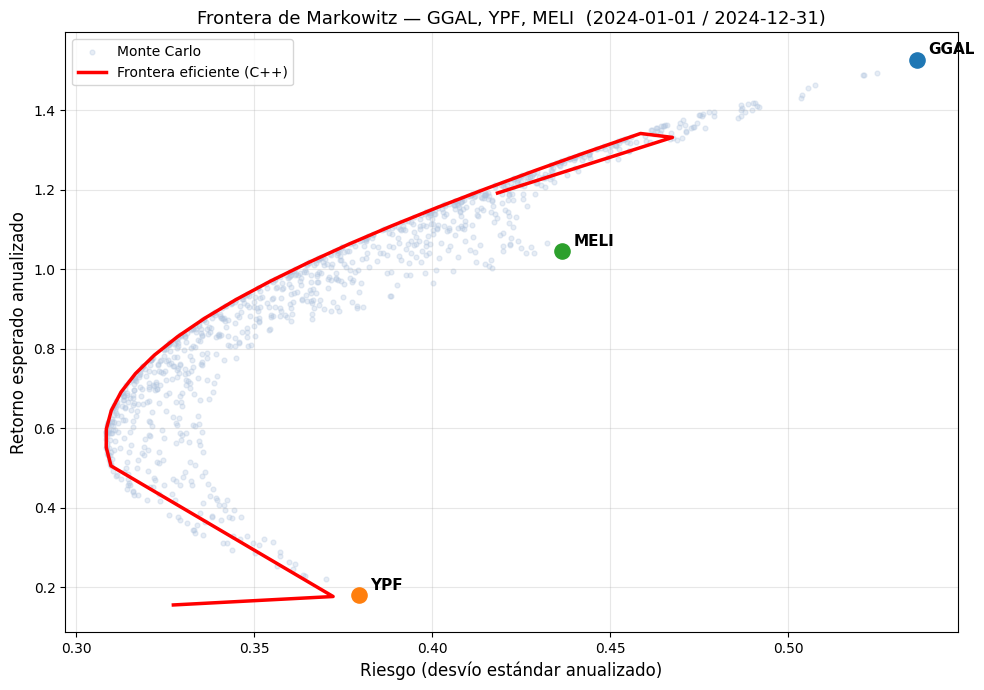

Gráfico guardado en frontier_test.png


In [9]:
import boto3
import pandas as pd
import numpy as np
import subprocess
import os
import matplotlib.pyplot as plt
from boto3.dynamodb.conditions import Key

# ── Config ────────────────────────────────────────────────────────────────────
TICKERS    = ["GGAL", "YPF", "MELI"]
START_DATE = "2024-01-01"
END_DATE   = "2024-12-31"
N_POINTS   = 30      # puntos en la frontera
N_MC       = 1000     # portfolios Monte Carlo de fondo

SOLVER_SRC = "/home/luke/Desktop/repositorios/markowitz_project/backend/portfolio_solver.cpp"                                          
SOLVER_BIN = "/home/luke/Desktop/repositorios/markowitz_project/backend/portfolio_solver"

# ── 0. Compilar solver si hace falta ─────────────────────────────────────────
if not os.path.exists(SOLVER_BIN) or \
   os.path.getmtime(SOLVER_SRC) > os.path.getmtime(SOLVER_BIN):
    print("Compilando portfolio_solver.cpp ...")
    result = subprocess.run(
        ["g++", "-O2", "-o", SOLVER_BIN, SOLVER_SRC],
        capture_output=True, text=True
    )
    if result.returncode != 0:
        raise RuntimeError(f"Error de compilación:\n{result.stderr}")
    print("Compilado OK")

# ── 1. Bajar datos de DynamoDB ────────────────────────────────────────────────
dynamodb = boto3.resource("dynamodb", region_name="us-east-1")
table    = dynamodb.Table("stock_prices")

all_data = []
for ticker in TICKERS:
    response = table.query(
        KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(START_DATE, END_DATE)
    )
    items = response.get("Items", [])
    while "LastEvaluatedKey" in response:
        response = table.query(
            KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(START_DATE, END_DATE),
            ExclusiveStartKey=response["LastEvaluatedKey"]
        )
        items.extend(response.get("Items", []))
    all_data.extend(items)

raw_df = pd.DataFrame(all_data)
raw_df["close"] = raw_df["close"].astype(float)
df = raw_df.pivot(index="date", columns="ticker", values="close").dropna()
print(f"Datos: {len(df)} filas × {len(df.columns)} tickers")

# ── 2. Parámetros anualizados ─────────────────────────────────────────────────
daily_returns = df.pct_change().dropna()
mu  = daily_returns.mean().values * 252
cov = daily_returns.cov().values * 252
n   = len(TICKERS)

# ── 3. Monte Carlo ────────────────────────────────────────────────────────────
mc_risks, mc_returns = [], []
for _ in range(N_MC):
    w = np.random.dirichlet(np.ones(n))
    mc_returns.append(float(w @ mu))
    mc_risks.append(float(np.sqrt(w @ cov @ w)))

# ── 4. Frontera eficiente vía binario C++ ─────────────────────────────────────
target_returns = np.linspace(mu.min(), mu.max(), N_POINTS)

# Construir input para el solver
lines = [str(n)]
lines.append(" ".join(f"{x:.10f}" for x in mu))
for row in cov:
    lines.append(" ".join(f"{x:.10f}" for x in row))
lines.append(str(N_POINTS))
lines.append(" ".join(f"{x:.10f}" for x in target_returns))
solver_input = "\n".join(lines)

result = subprocess.run(
    [SOLVER_BIN],
    input=solver_input,
    capture_output=True, text=True
)
if result.returncode != 0:
    raise RuntimeError(f"Error del solver:\n{result.stderr}")

frontier_risks, frontier_returns = [], []
for line in result.stdout.strip().split("\n"):
    if line.strip():
        risk, ret = map(float, line.split())
        frontier_risks.append(risk)
        frontier_returns.append(ret)

print(f"Frontera: {len(frontier_risks)} puntos")

# ── 5. Activos individuales ───────────────────────────────────────────────────
asset_risks   = [float(np.sqrt(cov[i, i])) for i in range(n)]
asset_returns = list(mu)

# ── 6. Plot ───────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(mc_risks, mc_returns, c="lightsteelblue", alpha=0.3, s=12, label="Monte Carlo")
ax.plot(frontier_risks, frontier_returns, "r-", linewidth=2.5, label="Frontera eficiente (C++)")
for i, ticker in enumerate(TICKERS):
    ax.scatter(asset_risks[i], asset_returns[i], s=120, zorder=5)
    ax.annotate(ticker, (asset_risks[i], asset_returns[i]),
                textcoords="offset points", xytext=(8, 4), fontsize=11, fontweight="bold")

ax.set_xlabel("Riesgo (desvío estándar anualizado)", fontsize=12)
ax.set_ylabel("Retorno esperado anualizado", fontsize=12)
ax.set_title(f"Frontera de Markowitz — {', '.join(TICKERS)}  ({START_DATE} / {END_DATE})", fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("frontier_test.png", dpi=150)
plt.show()
print("Gráfico guardado en frontier_test.png")
